# Introduction

This model will serve as our first foray into time-series forecasting using LSTMs. We will be following [this tutorial](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/).

The code will be broken into the following sections:

```{raw}
III. Model Creation
IV. Model Training
V. Next Steps
```

# I. Data and Imports

In [17]:
import numpy as np
import tensorflow as tf
import pandas as pd
import h5py
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [18]:
BATCH_SIZE = 64
EPOCHS = 5

NUM_PLAYS = 21
NUM_FEATURES = 35
hidden_size = 128
MASK_VAL = -1.1

In [19]:
# Import data from .h5 file

# Load data from the HDF5 file
with h5py.File('lstm_preprocessed_data.h5', 'r') as hf:
    x = hf['X'][:]
    y = hf['y'][:]

In [20]:
x_train, x_test = x[:-64000], x[-64000:]
y_train, y_test = y[:-64000], y[-64000:]

# III. Model Creation

Here, we create a fairly standard LSTM model, which outputs vectors of shape (1, 35), matching the next-play in the sequence.

We would like to further explore our optimizer and loss functions, as well as various model architectures.

### III.a Normalization Layer

In [21]:
norm_layer = layers.Normalization(axis=-1)
norm_layer.adapt(x_train)

In [22]:
# NUM_DRIVES = 58279


# Creating basic 2 layer LSTM
model = Sequential([
    layers.Input((NUM_PLAYS, NUM_FEATURES)), 
    layers.Masking(mask_value=MASK_VAL),
    norm_layer, 
    layers.BatchNormalization(),
    layers.LSTM(hidden_size, recurrent_activation="tanh", kernel_regularizer="l2", return_sequences=True),
    layers.BatchNormalization(),
    layers.LSTM(hidden_size, recurrent_activation="tanh", kernel_regularizer="l2"),
    layers.BatchNormalization(),
    layers.Dense(NUM_FEATURES)
])

# TODO: Explore model params. Add momentum to optimizer? MSE because this feels like more of a regression problem.
model.compile(optimizer='adam',
                loss="mean_squared_error",
                metrics=['accuracy', "MSE"])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 21, 35)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 21, 35)         │            71 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 35)         │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 21, 128)        │        83,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,302 (864.46 KB)

 Trainable params: 220,649 (861.91 KB)

 Non-trainable params: 653 (2.55 KB)

# IV. Model Training

As you can see, the model trains quite well, achieving an accuracy of 54%.

We would like to add validation data to the model to ensure that it is not overfitting.

In [23]:
# Fit the model
history = model.fit(x=x_train, y=y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/5
4011/4011 ━━━━━━━━━━━━━━━━━━━━ 187s 46ms/step - MSE: 97128.5312 - accuracy: 0.5043 - loss: 97131.4531
Epoch 2/5
4011/4011 ━━━━━━━━━━━━━━━━━━━━ 187s 47ms/step - MSE: 947.6272 - accuracy: 0.6625 - loss: 952.1785
Epoch 3/5
4011/4011 ━━━━━━━━━━━━━━━━━━━━ 187s 47ms/step - MSE: 867.5002 - accuracy: 0.6605 - loss: 872.9282
Epoch 4/5
4011/4011 ━━━━━━━━━━━━━━━━━━━━ 184s 46ms/step - MSE: 821.7795 - accuracy: 0.6566 - loss: 828.0368
Epoch 5/5
4011/4011 ━━━━━━━━━━━━━━━━━━━━ 184s 46ms/step - MSE: 825.4240 - accuracy: 0.6680 - loss: 832.6891


In [24]:
model.evaluate(x=x_test, y=y_test)

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - MSE: 210.3732 - accuracy: 0.7892 - loss: 218.2564


[421.4692687988281, 0.780078113079071, 413.58612060546875]

## Plot Model

In [35]:
!brew install graphviz

To reinstall 12.2.0, run:
  brew reinstall graphviz


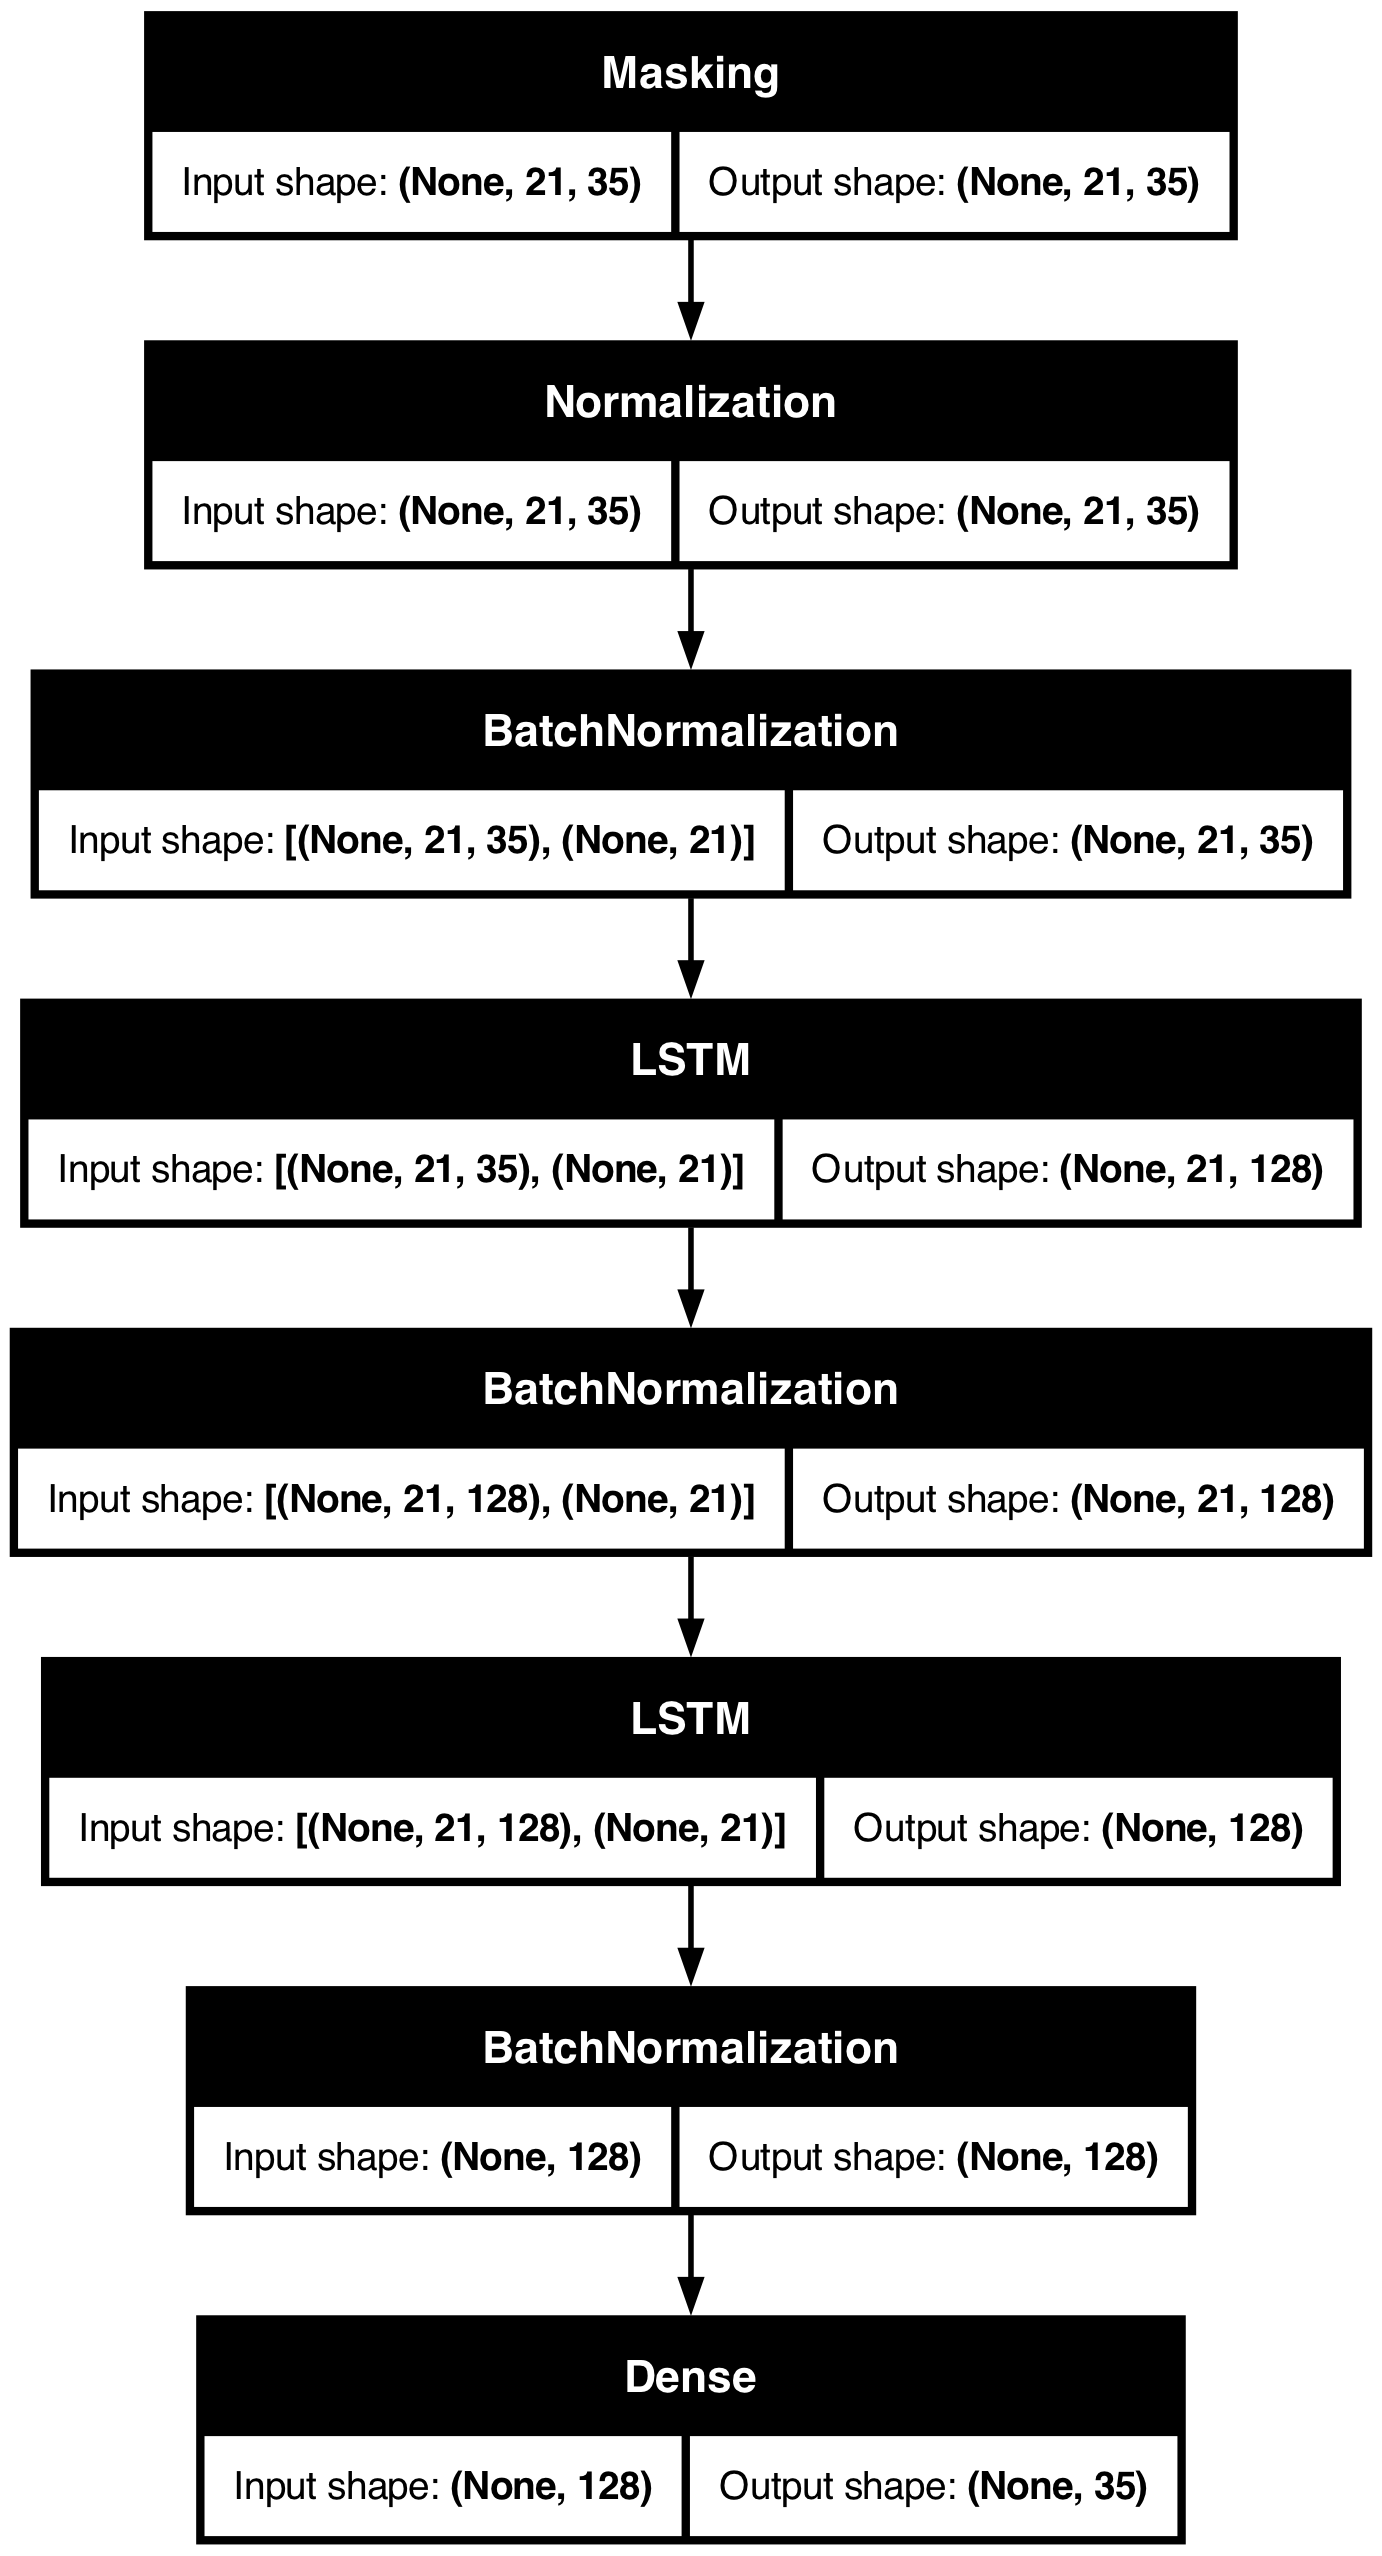

In [36]:
tf.keras.utils.plot_model(model=model,
         show_shapes=True, to_file='./lstm.png')

# V. Next Steps

1. Experiment with various model architectures and frameworks
   1. LSTM
   2. GRU
   3. Transformer
   4. Encoder-Decoder
2. Hyperparameter optimization
   1. Loss function
   2. Optimizer
   3. Regularization
   4. Weight normalization
   5. Model architectures
3. Dataset preparation
   1. Normalization
   2. Revisit feature selection
   3. Look into time-series methods (`tf.keras.preprocessing.timeseries_dataset_from_array`)

- Use None for first input shape for variable length sequence model inputs?
- use preprocessing.pad_sequences
- https://chatgpt.com/share/674f7ebb-778c-8011-a993-bd83320c73b8